In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import OutfitsDataset
from models import *
from visualizations import plot_loss_curves, plot_roc_curve
from evaluate import compute_metrics

c:\Users\hecan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set DataLoaders

In [2]:
# Load dataframes
train_img = pd.read_csv('Normal_Outfits_Data/train4siamese.csv')
test_img = pd.read_csv('Normal_Outfits_Data/test4siamese.csv')
train_desc = pd.read_csv('train4clip.csv')
test_desc = pd.read_csv('test4clip.csv')

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, saturation=0.5),
    transforms.ToTensor()
])

# Create datasets
train_dataset = OutfitsDataset(train_img, train_desc, transform=train_transform)
test_dataset = OutfitsDataset(test_img, test_desc, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Define MultiModal Predictor

In [3]:
class MultiModalPredictorVC(nn.Module):
    def __init__(self, weights_path = 'best_model.pt'):
        super(MultiModalPredictorVC, self).__init__()
        self.visual_model = VisualFeatureExtractor().cuda()
        self.textual_model = TextualFeatureExtractor().cuda()

        self.__set_visual_model(weights_path)

        self.fc = nn.Sequential(
            nn.Linear(4480, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def __set_visual_model(self, weights_path):
        # load the pretrained weights trained for binary classification
        weights = torch.load(weights_path)
        
        # remove the final classification layers
        weights_to_remove = ["fc.0.weight", "fc.0.bias", "fc.1.weight", "fc.1.bias", "fc.4.weight", "fc.4.bias"]
        for k in weights_to_remove:
            weights.pop(k)

        self.visual_model.load_state_dict(weights)

    def forward(self, imgs, texts):
        img_features = self.visual_model(imgs)
        text_features= self.textual_model(texts)

        all_features = torch.cat([img_features, text_features], dim=1)

        return self.fc(all_features)

## Training

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MultiModalPredictorVC().to(device)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [5]:
best_acc = 0.7

# Training and validation loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for img_inputs, text_inputs, labels in tqdm(train_loader):
        img_inputs = [part.to(device) for part in img_inputs]
        text_inputs = text_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(img_inputs, text_inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for img_inputs, text_inputs, labels in test_loader:
            img_inputs = [part.to(device) for part in img_inputs]
            text_inputs = text_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(img_inputs, text_inputs).squeeze()
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * labels.size(0)
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

        val_loss = val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val /  total_val
    if val_accuracy > best_acc:
        torch.save(model.state_dict(), 'best_vc.pt')
        best_acc = val_accuracy
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

  0%|          | 0/822 [00:00<?, ?it/s]c:\Users\hecan\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(
100%|██████████| 822/822 [13:07<00:00,  1.04it/s]


Epoch 1/10, Train Loss: 0.6830, Train Accuracy: 0.5440, Val Loss: 0.9284, Val Accuracy: 0.5072


100%|██████████| 822/822 [12:57<00:00,  1.06it/s]


Epoch 2/10, Train Loss: 0.5367, Train Accuracy: 0.7357, Val Loss: 0.5707, Val Accuracy: 0.7062


100%|██████████| 822/822 [12:12<00:00,  1.12it/s]


Epoch 3/10, Train Loss: 0.4594, Train Accuracy: 0.7832, Val Loss: 0.6393, Val Accuracy: 0.6613


100%|██████████| 822/822 [12:17<00:00,  1.12it/s]


Epoch 4/10, Train Loss: 0.4191, Train Accuracy: 0.8087, Val Loss: 0.5957, Val Accuracy: 0.7243


100%|██████████| 822/822 [12:10<00:00,  1.13it/s]


Epoch 5/10, Train Loss: 0.3927, Train Accuracy: 0.8237, Val Loss: 0.7246, Val Accuracy: 0.6836


100%|██████████| 822/822 [12:02<00:00,  1.14it/s]


Epoch 6/10, Train Loss: 0.3616, Train Accuracy: 0.8409, Val Loss: 0.6197, Val Accuracy: 0.7185


100%|██████████| 822/822 [12:01<00:00,  1.14it/s]


Epoch 7/10, Train Loss: 0.3434, Train Accuracy: 0.8518, Val Loss: 0.5890, Val Accuracy: 0.7175


100%|██████████| 822/822 [11:56<00:00,  1.15it/s]


Epoch 8/10, Train Loss: 0.3263, Train Accuracy: 0.8577, Val Loss: 0.5906, Val Accuracy: 0.7305


100%|██████████| 822/822 [12:01<00:00,  1.14it/s]


Epoch 9/10, Train Loss: 0.3099, Train Accuracy: 0.8670, Val Loss: 0.6850, Val Accuracy: 0.7024


100%|██████████| 822/822 [11:54<00:00,  1.15it/s]


Epoch 10/10, Train Loss: 0.2880, Train Accuracy: 0.8809, Val Loss: 0.6679, Val Accuracy: 0.7284


## Visualize Training

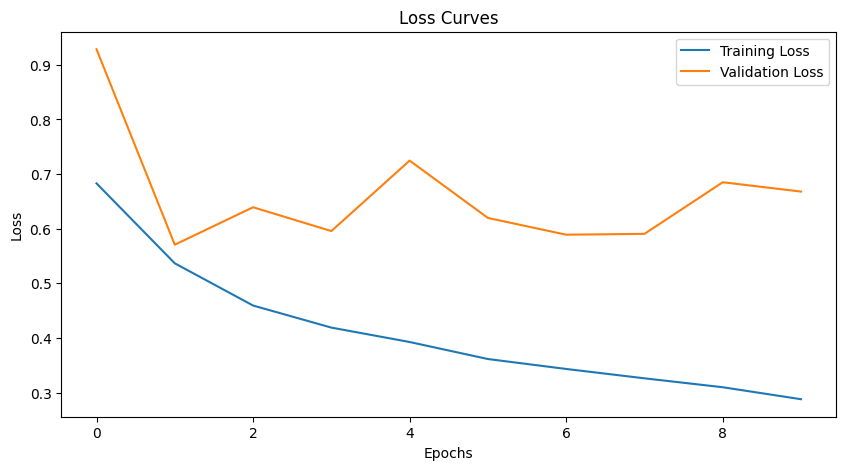

In [6]:
# plot learning curves
plot_loss_curves(train_losses, val_losses)

## Evaluate

In [11]:
model = MultiModalPredictorVC().to(device)
model.load_state_dict(torch.load('best_vc.pt'))
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for img_inputs, text_inputs, labels in tqdm(test_loader):
        img_inputs = [part.to(device) for part in img_inputs]
        text_inputs = text_inputs.to(device)
        labels = labels.to(device)
        outputs = model(img_inputs, text_inputs)
        preds = outputs.cpu().numpy()  # Assuming a sigmoid activation for binary classification
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

100%|██████████| 92/92 [00:57<00:00,  1.60it/s]


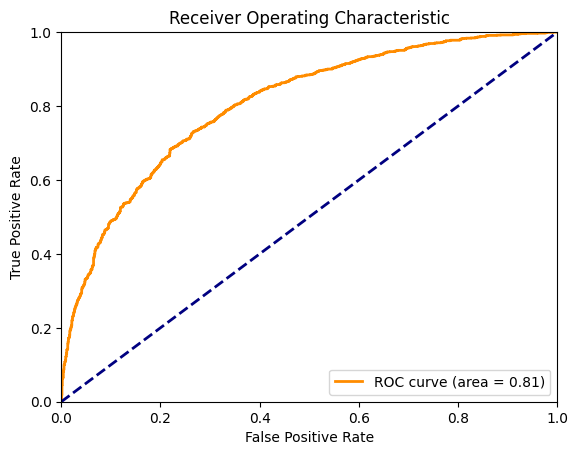

In [12]:
# plot ROC curve
plot_roc_curve(all_labels, all_preds)

In [13]:
metrics = compute_metrics(all_labels, all_preds)
print(metrics)

{'auc': 0.8050431600675548, 'accuracy': 0.7304794520547945, 'precision': 0.7284453496266123, 'recall': 0.7349315068493151, 'f1_score': 0.7316740538697579}
